In [1]:
###Training Data

In [4]:
# lstm autoencoder to recreate a timeseries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
'''
A UDF to convert input data into 3-D
array as required for LSTM network.

'''
df = pd.read_csv('/content/sample_data/all_motor_data.csv',header=None)
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

# define input timeseries
timeseries = np.array([df[0].values,df[1].values,df[2].values,df[3].values]).transpose()



timesteps = 10
X, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)

n_features = 4
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)


print(X.shape)

(24554, 10, 4)


In [5]:
# load model
model = load_model('/content/sample_data/weights-improvement-97-0.98.hdf5')
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 256)           267264    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 4)             1028      
Total params: 991,236
Trainable params: 991,236
Non-trainable params: 0
________________________________________________

In [6]:
x_train_pred = model.predict(X, verbose=1)

768/768 [==============================] - 20s 26ms/step


In [7]:
x_array_pred = np.zeros(shape = (x_train_pred.shape[0],x_train_pred.shape[1],1))
y_array_pred = np.zeros(shape = (x_train_pred.shape[0],x_train_pred.shape[1],1))
z_array_pred = np.zeros(shape = (x_train_pred.shape[0],x_train_pred.shape[1],1))
amp_array_pred = np.zeros(shape = (x_train_pred.shape[0],x_train_pred.shape[1],1))

x_array = np.zeros(shape = (x_train_pred.shape[0],x_train_pred.shape[1],1))
y_array = np.zeros(shape = (x_train_pred.shape[0],x_train_pred.shape[1],1))
z_array = np.zeros(shape = (x_train_pred.shape[0],x_train_pred.shape[1],1))
amp_array = np.zeros(shape = (x_train_pred.shape[0],x_train_pred.shape[1],1))

In [8]:
for i in range(0,x_train_pred.shape[0]):
  for j in range(0, x_train_pred.shape[1]):
    x_array_pred[i][j] = x_train_pred[i][j][0]
    y_array_pred[i][j] = x_train_pred[i][j][1]
    z_array_pred[i][j] = x_train_pred[i][j][2]
    amp_array_pred[i][j] = x_train_pred[i][j][3]

    x_array[i][j] = X[i][j][0]
    y_array[i][j] = X[i][j][1]
    z_array[i][j] = X[i][j][2]
    amp_array[i][j] = X[i][j][3] 

In [9]:
#Mean Average Errors
train_mae_loss_x = np.mean(np.abs(x_array_pred - x_array),axis = 1)
train_mae_loss_y = np.mean(np.abs(y_array_pred - y_array),axis = 1)
train_mae_loss_z = np.mean(np.abs(z_array_pred - z_array),axis = 1)
train_mae_loss_amp = np.mean(np.abs(amp_array_pred - amp_array),axis = 1)

Reconstruction error threshold: 6.17099484372139


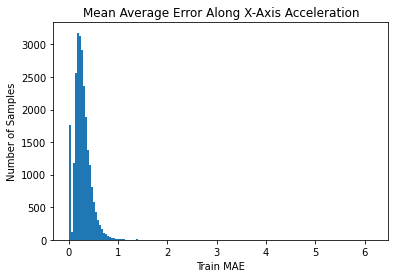

In [17]:
plt.hist(train_mae_loss_x, bins=150)
plt.xlabel("Train MAE")
plt.ylabel("Number of Samples")
plt.title("Mean Average Error Along X-Axis Acceleration")

threshold_x = np.max(train_mae_loss_x)
print(f'Reconstruction error threshold: {threshold_x}')

Reconstruction error threshold: 3.711390591144563


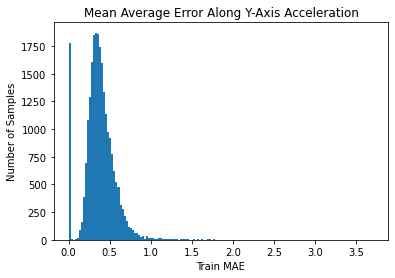

In [18]:
plt.hist(train_mae_loss_y, bins=150)
plt.xlabel("Train MAE")
plt.ylabel("Number of Samples")
plt.title("Mean Average Error Along Y-Axis Acceleration")

threshold_y = np.max(train_mae_loss_y)
print(f'Reconstruction error threshold: {threshold_y}')

Reconstruction error threshold: 6.475497664451599


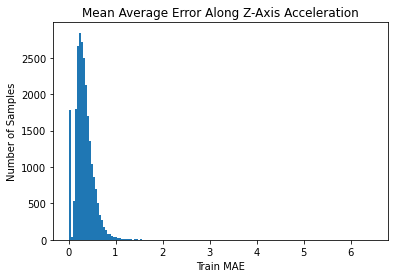

In [19]:
plt.hist(train_mae_loss_z, bins=150)
plt.xlabel("Train MAE")
plt.ylabel("Number of Samples")
plt.title("Mean Average Error Along Z-Axis Acceleration")

threshold_z = np.max(train_mae_loss_z)
print(f'Reconstruction error threshold: {threshold_z}')

Reconstruction error threshold: 0.14692111110687256


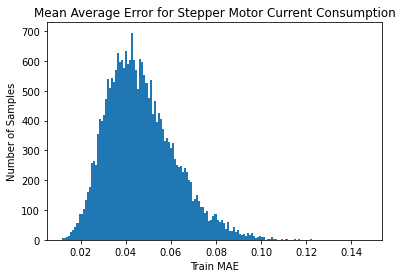

In [20]:
plt.hist(train_mae_loss_amp, bins=150)
plt.xlabel("Train MAE")
plt.ylabel("Number of Samples")
plt.title("Mean Average Error for Stepper Motor Current Consumption")

threshold_amp = np.max(train_mae_loss_amp)
print(f'Reconstruction error threshold: {threshold_amp}')

In [21]:
###Anomaly Data

In [22]:
a_df = pd.read_csv('/content/sample_data/anomaly_data.csv',header=None)

In [23]:
# define input timeseries
timeseries_a = np.array([a_df[0].values,a_df[1].values,a_df[2].values,a_df[3].values]).transpose()

X_a, y_a = temporalize(X = timeseries_a, y = np.zeros(len(timeseries_a)), lookback = timesteps)

In [24]:
X_a = np.array(X_a)
X_a = X_a.reshape(X_a.shape[0], timesteps, n_features)
print(X_a.shape)

(5165, 10, 4)


In [25]:
x_test = model.predict(X_a, verbose=0)

In [26]:
anomaly_x_pred = np.zeros(shape = (x_test.shape[0],x_test.shape[1],1))
anomaly_y_pred = np.zeros(shape = (x_test.shape[0],x_test.shape[1],1))
anomaly_z_pred = np.zeros(shape = (x_test.shape[0],x_test.shape[1],1))
anomaly_amp_pred = np.zeros(shape = (x_test.shape[0],x_test.shape[1],1))

anomaly_x = np.zeros(shape = (x_test.shape[0],x_test.shape[1],1))
anomaly_y = np.zeros(shape = (x_test.shape[0],x_test.shape[1],1))
anomaly_z = np.zeros(shape = (x_test.shape[0],x_test.shape[1],1))
anomaly_amp = np.zeros(shape = (x_test.shape[0],x_test.shape[1],1))

In [27]:
for i in range(0,x_test.shape[0]):
  for j in range(0, x_test.shape[1]):
    anomaly_x_pred[i][j] = x_test[i][j][0]
    anomaly_y_pred[i][j] = x_test[i][j][1]
    anomaly_z_pred[i][j] = x_test[i][j][2]
    anomaly_amp_pred[i][j] = x_test[i][j][3]

    anomaly_x[i][j] = X_a[i][j][0]
    anomaly_y[i][j] = X_a[i][j][1]
    anomaly_z[i][j] = X_a[i][j][2]
    anomaly_amp[i][j] = X_a[i][j][3] 

In [45]:
#Anomaly Mean Average Errors
test_mae_loss_x = np.mean(np.abs(anomaly_x_pred - anomaly_x),axis = 1)
test_mae_loss_y = np.mean(np.abs(anomaly_y_pred - anomaly_y),axis = 1)
test_mae_loss_z = np.mean(np.abs(anomaly_z_pred - anomaly_z),axis = 1)
test_mae_loss_amp = np.mean(np.abs(anomaly_amp_pred - anomaly_amp),axis = 1)

Reconstruction error threshold: 6.308611881732941


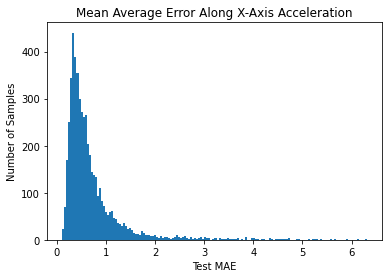

In [46]:
plt.hist(test_mae_loss_x, bins=150)
plt.xlabel("Test MAE")
plt.ylabel("Number of Samples")
plt.title("Mean Average Error Along X-Axis Acceleration")

threshold_a_x = np.max(test_mae_loss_x)
print(f'Reconstruction error threshold: {threshold_a_x}')

Reconstruction error threshold: 6.398523383855819


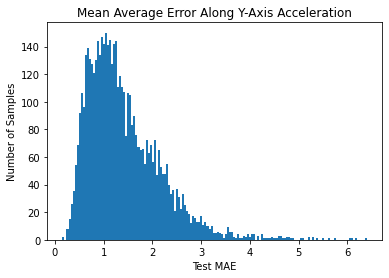

In [30]:
plt.hist(test_mae_loss_y, bins=150)
plt.xlabel("Test MAE")
plt.ylabel("Number of Samples")
plt.title("Mean Average Error Along Y-Axis Acceleration")

threshold_a_y = np.max(test_mae_loss_y)
print(f'Reconstruction error threshold: {threshold_a_y}')

Reconstruction error threshold: 6.790493705749512


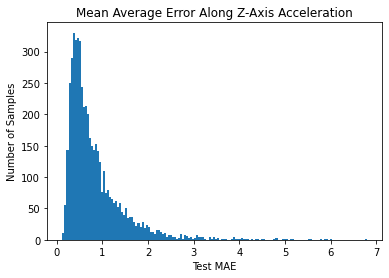

In [31]:
plt.hist(test_mae_loss_z, bins=150)
plt.xlabel("Test MAE")
plt.ylabel("Number of Samples")
plt.title("Mean Average Error Along Z-Axis Acceleration")

threshold_a_z = np.max(test_mae_loss_z)
print(f'Reconstruction error threshold: {threshold_a_z}')

Reconstruction error threshold: 0.49784875214099883


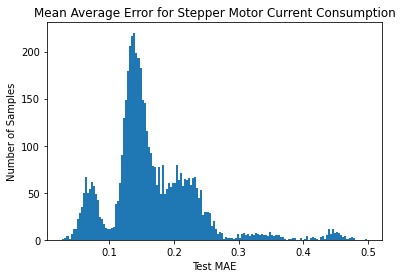

In [32]:
plt.hist(test_mae_loss_amp, bins=150)
plt.xlabel("Test MAE")
plt.ylabel("Number of Samples")
plt.title("Mean Average Error for Stepper Motor Current Consumption")

threshold_a_amp = np.max(test_mae_loss_amp)
print(f'Reconstruction error threshold: {threshold_a_amp}')

In [102]:
test_data = pd.DataFrame()

test_data['x_loss'] = test_mae_loss_x.flatten()
test_data['threshold_x'] = threshold_x
test_data['anomaly_x'] = test_data['x_loss'] > test_data['threshold_x']

test_data['y_loss'] = test_mae_loss_y
test_data['threshold_y'] = threshold_y
test_data['anomaly_y'] = test_data['y_loss'] > test_data['threshold_y']

test_data['z_loss'] = test_mae_loss_z
test_data['threshold_z'] = threshold_z
test_data['anomaly_z'] = test_data['z_loss'] > test_data['threshold_z']

test_data['amp_loss'] = test_mae_loss_amp
test_data['threshold_amp'] = threshold_amp
test_data['anomaly_amp'] = test_data['amp_loss'] > test_data['threshold_amp']



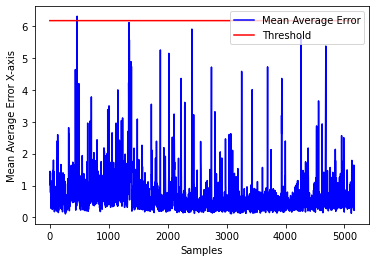

In [103]:
plt.plot(test_data['x_loss'],color='blue')
plt.plot(test_data['threshold_x'],color='red')
plt.legend(['Mean Average Error','Threshold'],loc="upper right")
plt.xlabel("Samples")
plt.ylabel("Mean Average Error X-axis")
plt.show()

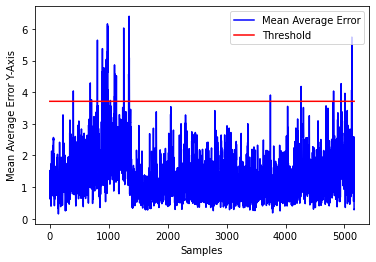

In [104]:
plt.plot(test_data['y_loss'],color='blue')
plt.plot(test_data['threshold_y'],color='red')
plt.legend(['Mean Average Error','Threshold'],loc="upper right")
plt.xlabel("Samples")
plt.ylabel("Mean Average Error Y-Axis")
plt.show()

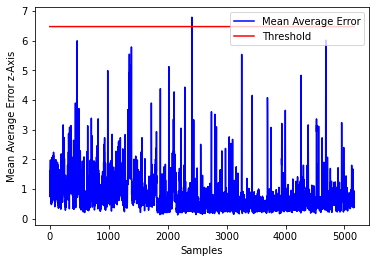

In [105]:
plt.plot(test_data['z_loss'],color='blue')
plt.plot(test_data['threshold_z'],color='red')
plt.legend(['Mean Average Error','Threshold'],loc="upper right")
plt.xlabel("Samples")
plt.ylabel("Mean Average Error z-Axis")
plt.show()

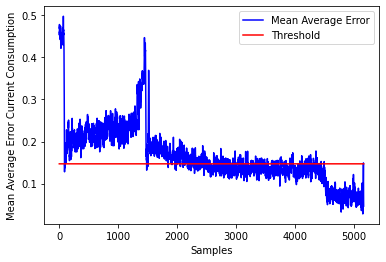

In [106]:
plt.plot(test_data['amp_loss'],color='blue')
plt.plot(test_data['threshold_amp'],color='red')
plt.legend(['Mean Average Error','Threshold'],loc="upper right")
plt.xlabel("Samples")
plt.ylabel("Mean Average Error Current Consumption")
plt.show()

In [107]:
x_anomalies = test_data.loc[test_data['anomaly_x'] == True]
y_anomalies = test_data.loc[test_data['anomaly_y']==True]
z_anomalies = test_data.loc[test_data['anomaly_z']==True]
amp_anomalies = test_data.loc[test_data['anomaly_amp']==True]

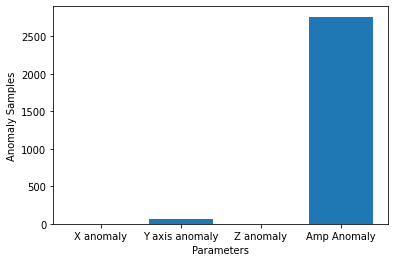

In [113]:
plt.bar(['X anomaly','Y axis anomaly','Z anomaly','Amp Anomaly'],[x_anomalies.shape[0],y_anomalies.shape[0],z_anomalies.shape[0],amp_anomalies.shape[0]])
plt.xlabel('Parameters')
plt.ylabel('Anomaly Samples')
plt.show()

In [98]:
test_mae_loss_amp.shape

(5165, 1)

In [100]:
anomaly_x.shape

(5165, 10, 1)

In [115]:
amp_anomalies

,x_loss,threshold_x,anomaly_x,y_loss,threshold_y,anomaly_y,z_loss,threshold_z,anomaly_z,amp_loss,threshold_amp,anomaly_amp
0,1.030773,6.170995,False,0.947386,3.711391,False,0.915524,6.475498,False,0.459688,0.146921,True
1,1.197333,6.170995,False,1.210102,3.711391,False,0.741976,6.475498,False,0.454166,0.146921,True
2,1.082926,6.170995,False,1.366258,3.711391,False,1.117808,6.475498,False,0.453074,0.146921,True
3,1.198208,6.170995,False,1.520513,3.711391,False,1.604883,6.475498,False,0.478176,0.146921,True
4,1.444318,6.170995,False,1.276417,3.711391,False,0.835984,6.475498,False,0.468266,0.146921,True
...,...,...,...,...,...,...,...,...,...,...,...,...
4409,0.412078,6.170995,False,1.047421,3.711391,False,0.637723,6.475498,False,0.147702,0.146921,True
4443,0.501328,6.170995,False,1.028969,3.711391,False,0.456392,6.475498,False,0.152599,0.146921,True
4492,1.095825,6.170995,False,1.521145,3.711391,False,0.620225,6.475498,False,0.147596,0.146921,True
4495,0.772684,6.170995,False,1.407726,3.711391,False,0.577317,6.475498,False,0.152354,0.146921,True
